In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm
from datetime import datetime  
import mplfinance as mpf
from functools import partial

In [2]:
def daily_K_line(event,n,open,close,high,low):
    # 日均事件K线
    T0open=event*open  # 以T0open作为基准
    pre_close = event * close.shift(axis = 1)
    data=pd.DataFrame(columns=['T'+str(j) for j in range(n)])
    for j in range(n):
        _open=(event*open.shift(-j,axis=1))/pre_close
        _close=(event*close.shift(-j,axis=1))/pre_close
        _low=(event*low.shift(-j,axis=1))/pre_close
        _high=(event*high.shift(-j,axis=1))/pre_close
        lst=[_open.mean().mean(),_close.mean().mean(),_low.mean().mean(),_high.mean().mean()]
        data['T'+str(j)]=lst
    data.index=['open','close','low','high']
    data=data.T
    data.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
    mpf.plot(data,type='candle',style='default')
    return data

In [9]:
stock_list = ff.read('close').index.str.startswith('30') | ff.read('close').index.str.startswith('68')
stock_list = ff.read('close').index[stock_list]
time_list = ff.read('close').loc[:,'20200825':'20240305'].columns

In [45]:
filter0 = ff.filter0.loc[stock_list,time_list]
up = ff.read('up').loc[stock_list,time_list] * filter0 
close = ff.read('close').loc[stock_list,time_list] * filter0
pre_close = ff.read('pre_close').loc[stock_list,time_list] *filter0
high = ff.read('high').loc[stock_list,time_list] * filter0
up_limit = ff.read('up_limit').loc[stock_list,time_list] * filter0

In [153]:
open_ = (ff.read('open')*ff.read('post')).loc[stock_list,time_list]
close_ = (ff.read('close')*ff.read('post')).loc[stock_list,time_list]
low_ = (ff.read('low')*ff.read('post')).loc[stock_list,time_list]
high_ = (ff.read('high')*ff.read('post')).loc[stock_list,time_list]

T0日最收盘价涨停 T-5日到T-1日，没有出现过收盘涨停


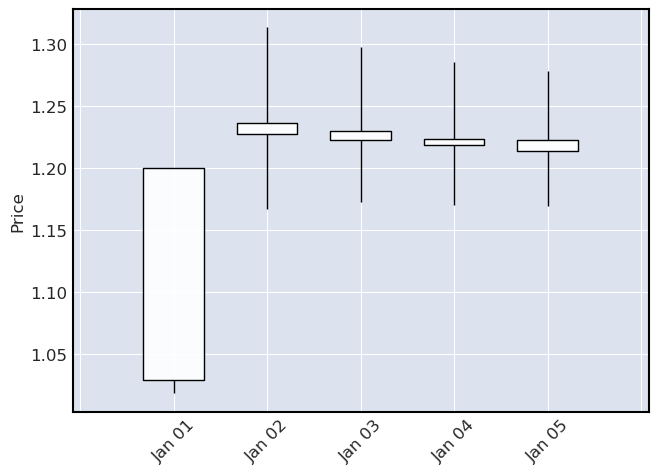

,open,close,low,high
2020-01-01,1.028766,1.200024,1.018306,1.200024
2020-01-02,1.226904,1.235857,1.167127,1.313077
2020-01-03,1.222504,1.229955,1.172216,1.297357
2020-01-04,1.218794,1.223605,1.170453,1.285090
2020-01-05,1.213441,1.222353,1.169325,1.277658


In [12]:
condition_1 = up
condition_2 = (close != up_limit).replace({True:1,False:0})
condition_2 = (condition_2.rolling(window = 5,axis = 1,closed = 'left').sum() == 5) #前五天的条件
event = (condition_1 * condition_2).replace({False:np.nan})
print('T0日最收盘价涨停 T-5日到T-1日，没有出现过收盘涨停')
daily_K_line(event,5,open_,close_,high_,low_)

T0日最高价涨停，收盘价未涨停 T-5日到T-1日，没有出现过收盘涨停


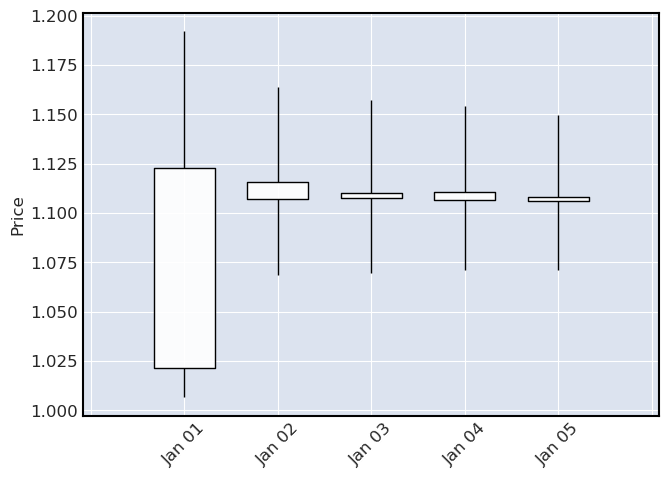

,open,close,low,high
2020-01-01,1.021502,1.122942,1.006647,1.192063
2020-01-02,1.107112,1.115710,1.068736,1.164062
2020-01-03,1.107724,1.110182,1.069582,1.157357
2020-01-04,1.106751,1.110852,1.071168,1.154215
2020-01-05,1.106312,1.108273,1.071050,1.149885


In [13]:
condition_1 = (high/up_limit>0.98) * (close/up_limit<0.98)
event = (condition_1 * condition_2).replace({False:np.nan,True:1})
print('T0日最高价涨停，收盘价未涨停 T-5日到T-1日，没有出现过收盘涨停')
daily_K_line(event,5,open_,close_,high_,low_)

盘中最高价涨幅大于15% T-5日到T-1日，没有出现过收盘涨停


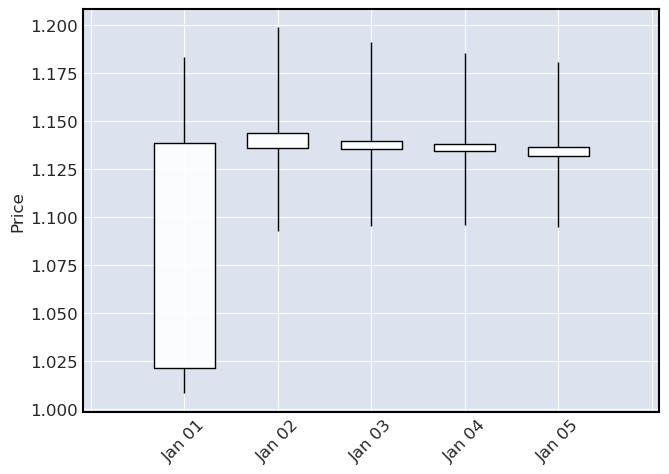

,open,close,low,high
2020-01-01,1.021751,1.138926,1.008389,1.183615
2020-01-02,1.136427,1.143997,1.092879,1.198962
2020-01-03,1.135624,1.139975,1.095372,1.191389
2020-01-04,1.134624,1.138015,1.095878,1.185799
2020-01-05,1.132220,1.136951,1.095293,1.181200


In [14]:
condition_1 = (high/pre_close > 1.15)
event = (condition_1 * condition_2).replace({False:np.nan,True:1})
print('盘中最高价涨幅大于15% T-5日到T-1日，没有出现过收盘涨停')
daily_K_line(event,5,open_,close_,high_,low_)

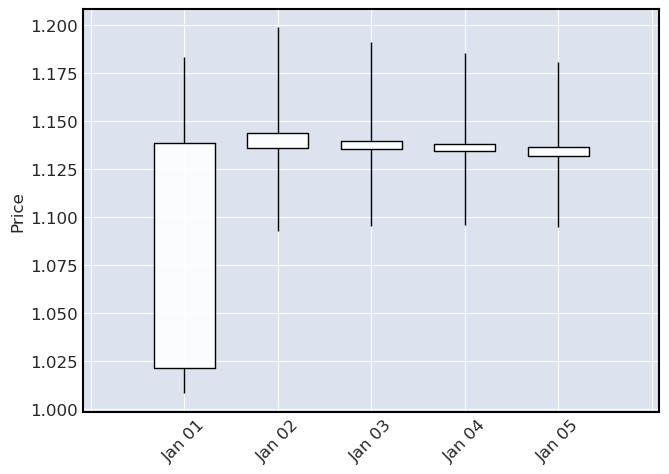

-0.00837267650943918

In [15]:
data = daily_K_line(event,5,open_,close_,high_,low_)
data.iloc[2,0] - data.iloc[1,1] 
# plt.plot(data.loc[:,'open':'close'].values.flatten()[1:]/data.iloc[0,1])

收盘价涨幅大于12%且不涨停 T-5日到T-1日，没有出现过收盘涨停


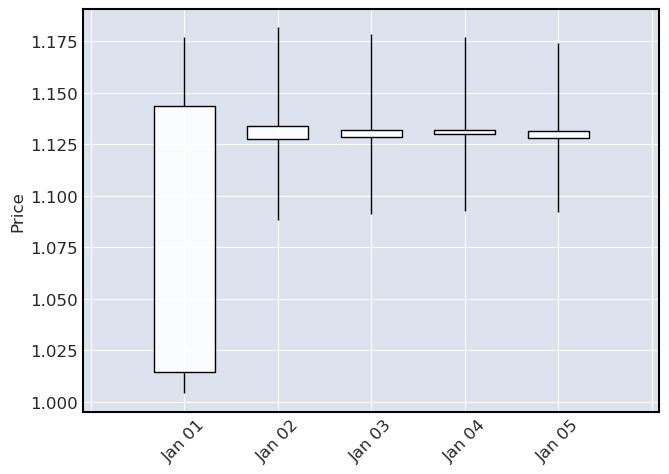

,open,close,low,high
2020-01-01,1.014502,1.143361,1.004033,1.176953
2020-01-02,1.127357,1.133818,1.088106,1.181728
2020-01-03,1.128332,1.131954,1.090990,1.178580
2020-01-04,1.129841,1.131987,1.092418,1.176962
2020-01-05,1.128186,1.131606,1.092310,1.173990


In [163]:
condition_1 = close/pre_close > 1.12
condition_2 = (close != up_limit).replace({True:1,False:0})
condition_2 = (condition_2.rolling(window = 6,axis = 1).sum() == 6) #前五天的条件
event = (condition_1 * condition_2).replace({False:np.nan})
print('收盘价涨幅大于12%且不涨停 T-5日到T-1日，没有出现过收盘涨停')
daily_K_line(event,5,open_,close_,high_,low_)

In [159]:
filter_first_up = pd.DataFrame(event,index = ff.read('close').index)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 854/854 [11:45<00:00,  1.21it/s]


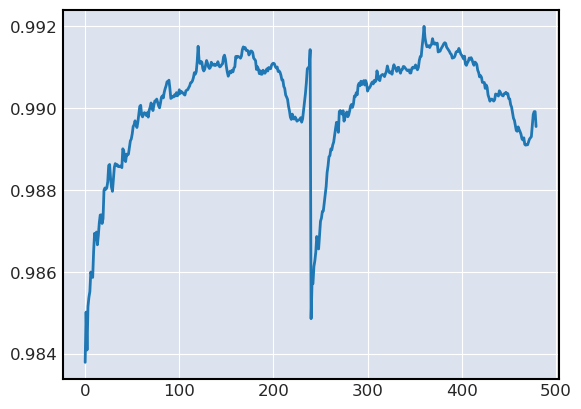

In [178]:
def stock_ret_mean(i):
    day = filter_first_up.columns[i]
    stock_ret_list = []
    for i in range(len(filter_first_up.loc[:,day].dropna().index)):
        if len(filter_first_up.loc[:,day].dropna().index) == 0:
            pass
        stock = filter_first_up.loc[:,day].dropna().index[i]
        formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(ff.read_min(stock).index)] #生成所有的分钟时间index
        time_start = formatted_date_list.index(day) 
        stock_ret_list.append((ff.read_min(stock).iloc[time_start+240:time_start+720,1]/ff.read_min(stock).iloc[time_start+239,1]).values)
    ret_aver = np.mean(stock_ret_list, axis=0)
    return ret_aver
ret_st_mean = []
with Pool(48) as p:
    ret_st_mean = list(tqdm(p.imap(stock_ret_mean, range(len(filter_first_up.columns))), total=len(filter_first_up.columns)))
mean_without_nan = [arr[~np.isnan(arr)] for arr in ret_st_mean]
mean_without_nan = [arr for arr in mean_without_nan if len(arr) > 0]
mean = np.mean(mean_without_nan,axis = 0)
plt.plot(mean)

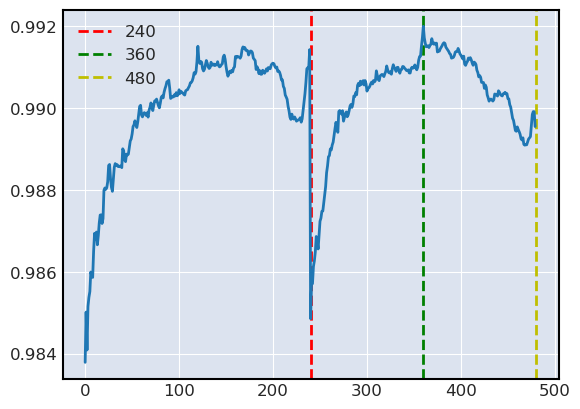

In [216]:
plt.axvline(240,c='r', label='240',linestyle='--')
plt.axvline(np.argmax(mean),c='g', label='360',linestyle='--')
plt.axvline(480,c='y', label='480',linestyle='--')
plt.legend()
plt.plot(mean)